# Introduction 

On the 18th of September 2017 a hurricane made landfall in Puerto Rico. Torrential rain and high winds caused extensive damage to infrastructure and led to widespread flooding https://en.wikipedia.org/wiki/Hurricane_Maria

In this tutorial we will use radar data provided by the European Space Agency Sentinel 1 Mission to identify flooded regions. We will do this using image segmentation and K-Means clustering. 

There are 3 preprocessed images, the first taken before the hurricane on 16/09/17, the second taken  just after the hurricane on 22/09/17 and the last taken one month after the hurricane on 22/10/17. ) 


In [1]:
# Import needed modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from sklearn import cluster,preprocessing

# Data pre processing

The instrument onboard the Sentinel-1 satellites transmits in one polarisation (V) and measures in two (V and H), giving the VV and VH bands. The first band in each data file is the signal measured in the same polarisation as the transmission (VV) and the second is measured in the orthogonal polarisation (VH).

We define a function load_data to read data from the numpy arrays. 

We define a second function to calculate the surface polarisation and add this as a third acces. The surface polarisation is the ratio of polarisation in the first two bands. 

In [2]:
# Define some useful functions

def load_data(filename):
    im=np.load(filename)
    return im

def data_preprocess(data_array):
    processed_data=np.zeros(np.shape(data_array))
    processed_data[:,:,0]=data_array[:,:,0]
    processed_data[:,:,1]=data_array[:,:,1]
    processed_data[:,:,2]=data_array[:,:,0]/data_array[:,:,1]
    return processed_data

In [3]:
# Load in data

radar_data=glob.glob('data/SAR*npy')
radar_data.sort()
day1=load_data(radar_data[2])
day2=load_data(radar_data[1])
day3=load_data(radar_data[0])

# Set third axis to be surface polarisation
day_1_preprocessed=data_preprocess(day1)
day_2_preprocessed=data_preprocess(day2)
day_3_preprocessed=data_preprocess(day3)


# Data Visualisation

Here we plot a subsection of the first day of data. We also define a subregion of the data that will be used for training the K-means clustering algorithm

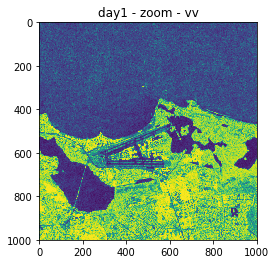

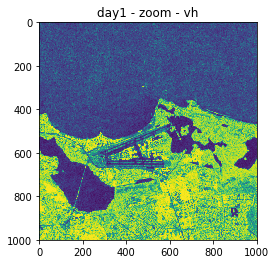

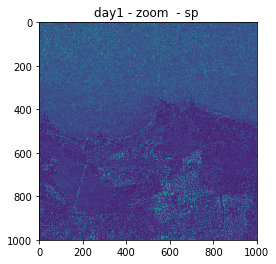

In [4]:
# Plot the first day of data
%matplotlib inline
#%matplotlib tk

plt.imshow(day_1_preprocessed[0:1000,2000:3000,0],'viridis')
plt.title('day1 - zoom - vv')
plt.show()

plt.imshow(day_1_preprocessed[0:1000,2000:3000,0],'viridis')
plt.title('day1 - zoom - vh')
plt.show()

plt.imshow(day_1_preprocessed[0:1000,2000:3000,2],'viridis')
plt.title('day1 - zoom  - sp ')
plt.show()


In [5]:
# Define subregions
day1_training=day_1_preprocessed[0:1000,2000:3000,:]
day1_test=day_1_preprocessed[400:1400,3300:4300,:]
day2_test=day_2_preprocessed[400:1400,3300:4300,:]
day3_test=day_3_preprocessed[400:1400,3300:4300,:]

# Image Segmentation

In the next section we use the segmetation module from scikit-image (http://scikit-image.org/docs/dev/api/skimage.segmentation.html) to create image segments. 
Each of these segments will be treated as a superpixel. We will calculate statiscs for each of the superpixels and use these as the input features for the K-means algorithm. 

The function calculate_segment_stats will calculate the minimum value, the maximum value, the mean, the variance, the skewness and the kurtosis of each super pixel for each band

** TODO Add in experiment thing **


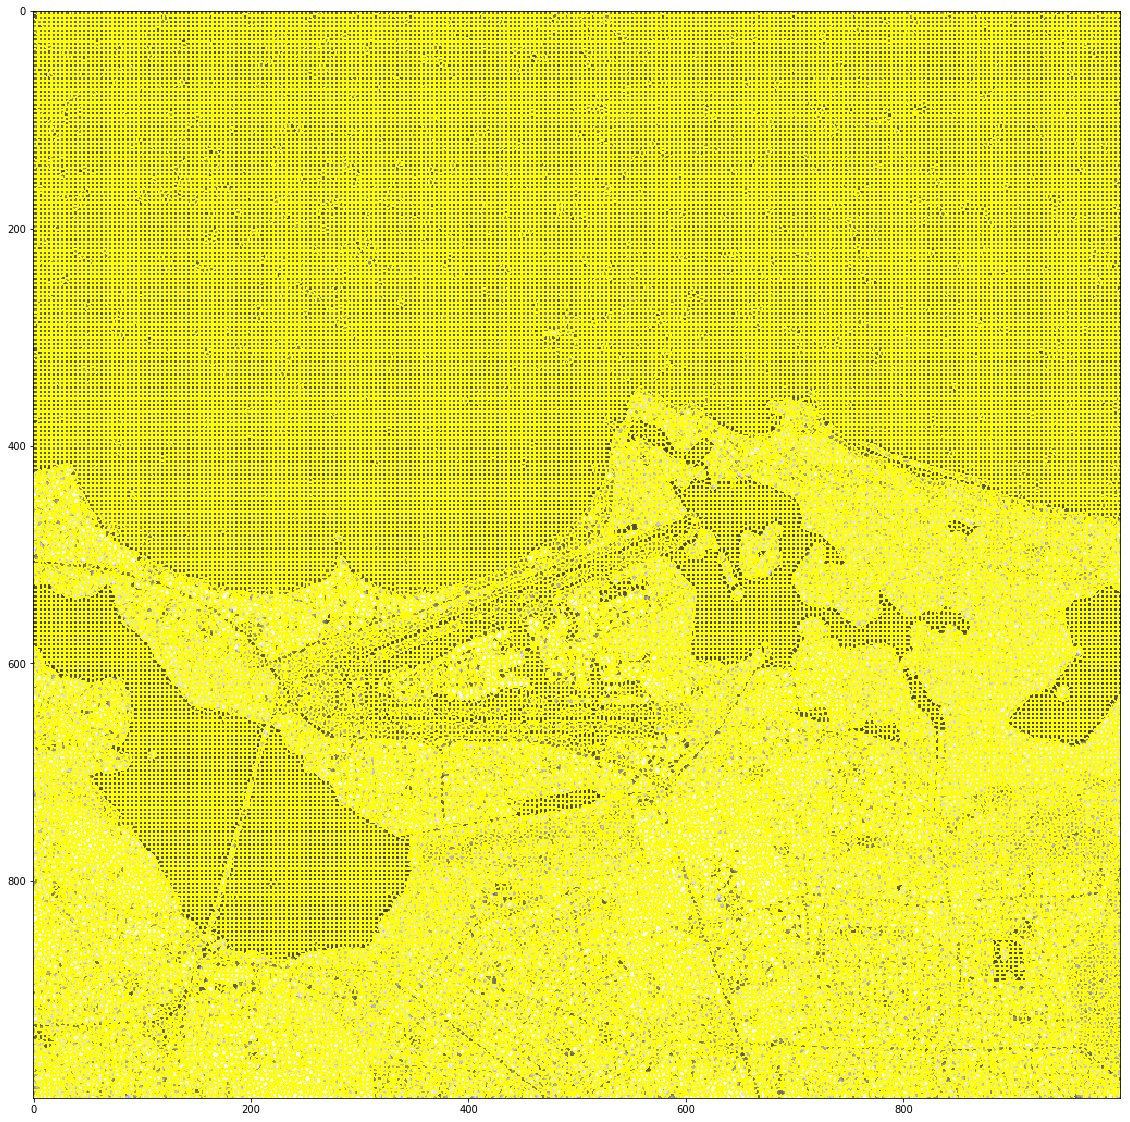

In [6]:
number_segments=50000
segments = slic(day1_training, n_segments=number_segments, compactness=50, sigma = 0,convert2lab=False)
plt.figure(figsize=(20,20))
plt.imshow(mark_boundaries(day1_training[:,:,0]/255, segments))
plt.show()

In [7]:
def calculate_segment_stats(data,segments):
    # turn the image into a 2D array (pix by channel)
    d1_flat = pd.DataFrame(np.ravel(data).reshape((-1,3)))

    # add the label vector
    d1_flat['spID'] = np.ravel(segments)

    # calculate the mean by segment
    return d1_flat.groupby('spID').mean().values

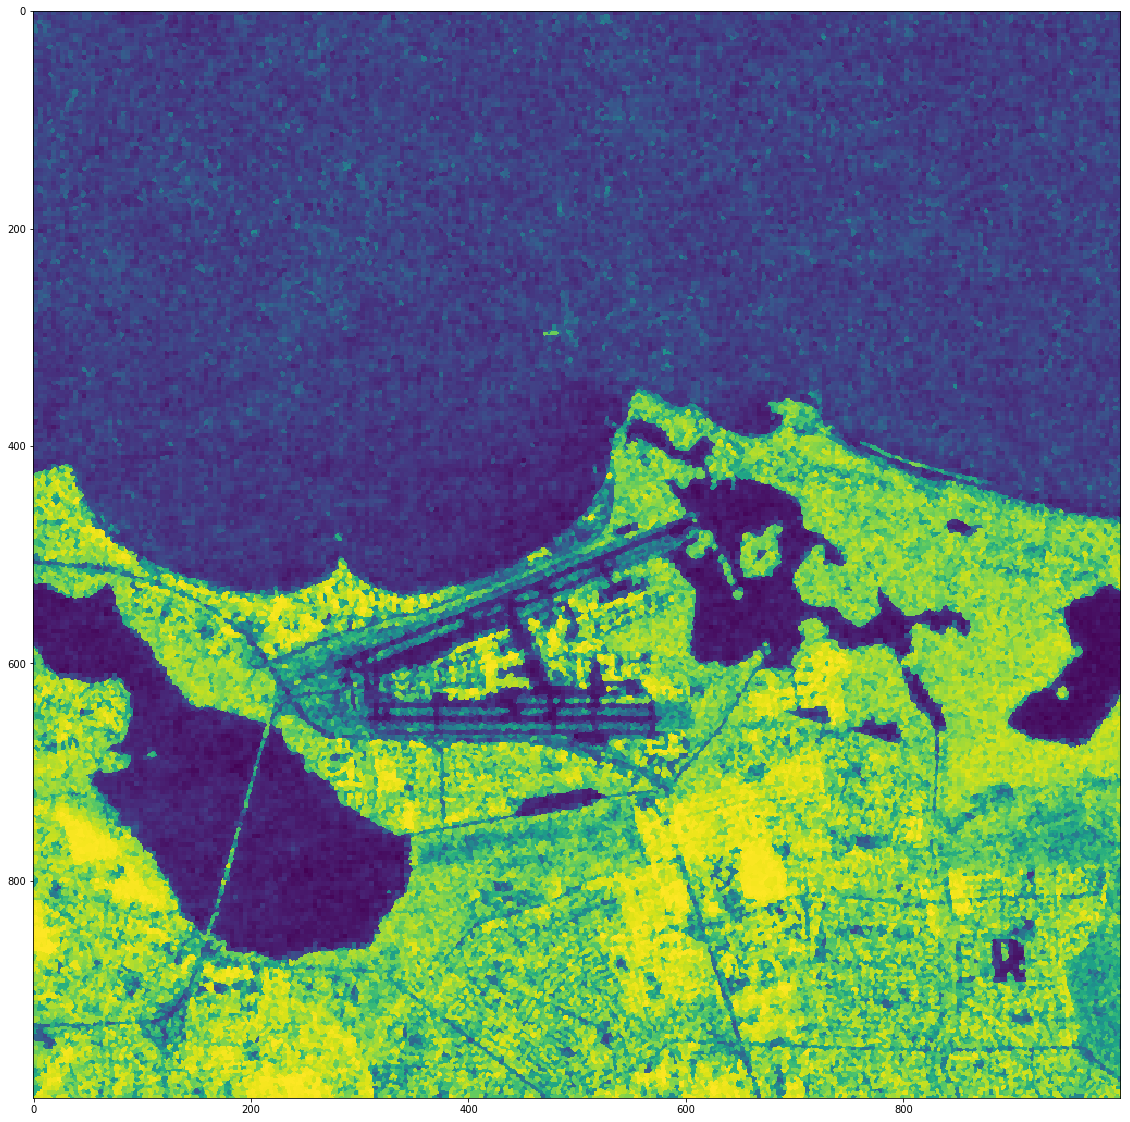

In [8]:
seg_means = calculate_segment_stats(day1_training,segments)
plt.figure(figsize=(20,20))
# broadcast the mean pixel values from the first channel
# to the same shape as the original image array
plt.imshow(seg_means[:,0][segments])

# K-Means clustering

In this section we will apply k-means clustering to the feature set defined above. We will search for three clusters in the data. 

We will then need to apply the segment classification to every pixel in the superpixel. 

In [9]:
kmeans_3clusters=cluster.KMeans(n_clusters=4)
kmeans_3clusters.fit(seg_means)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

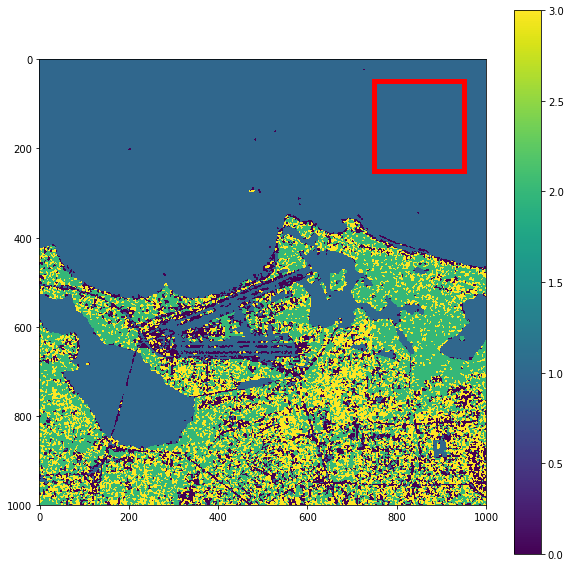

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(kmeans_3clusters.labels_[segments],'viridis')
rect = mpl.patches.Rectangle((750,50),200,200,linewidth=5,edgecolor='r',facecolor='none')
ax = plt.gca()
ax.add_patch(rect)
plt.colorbar()

# Detecting Flooding

From the above image we have some prior intuition that the area in the red square is ocean and so we can assume that the most common class in this region is going to represent water.

In [11]:
training = kmeans_3clusters.labels_[segments][50:250,750:950]
# should calculate mode, but mean will be fine as is almost all same class
water_label = int(training.mean())
print('The water label is {0}'.format(water_label))

The water label is 1


We are interested in applying this approach to a larger area, so we need a function to predict the label for new data. To do this, we simply wrap the model and slic algorithm into a function for convenience:

In [12]:
def predict(data, model, number_segments=number_segments):
    """ returns label image"""
    # segment the image
    test_segments = slic(data,
                         n_segments=number_segments,
                         compactness=50,
                         sigma = 0,
                         convert2lab=False)
    
    # calculate seg stats 
    test_set = calculate_segment_stats(data,test_segments)
    
    # predict
    test_set_segment_labels=model.predict(test_set)
    
    # code via broadcasting
    return test_set_segment_labels[test_segments]

We can then apply this to new areas:

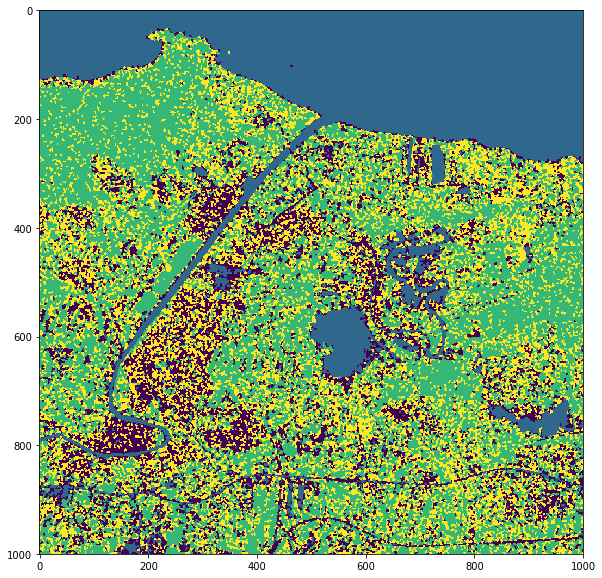

In [13]:
day1_labels=predict(day1_test,kmeans_3clusters)
plt.figure(figsize=(10,10))
plt.imshow(day1_labels)
plt.show()

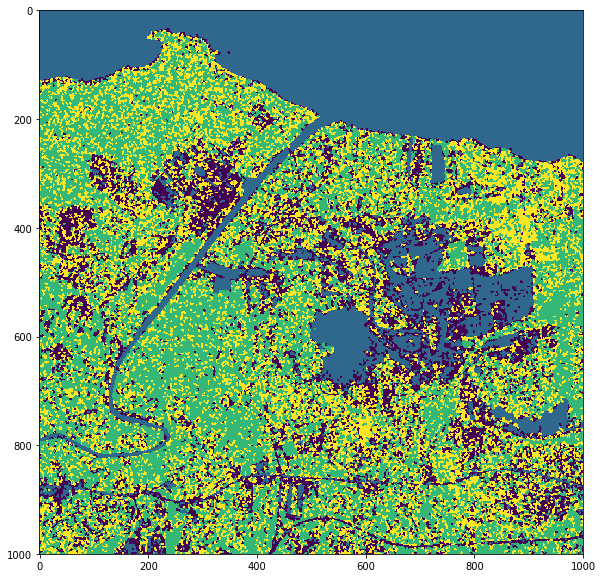

In [14]:
day2_labels=predict(day2_test,kmeans_3clusters)
plt.figure(figsize=(10,10))
plt.imshow(day2_labels)
plt.show()

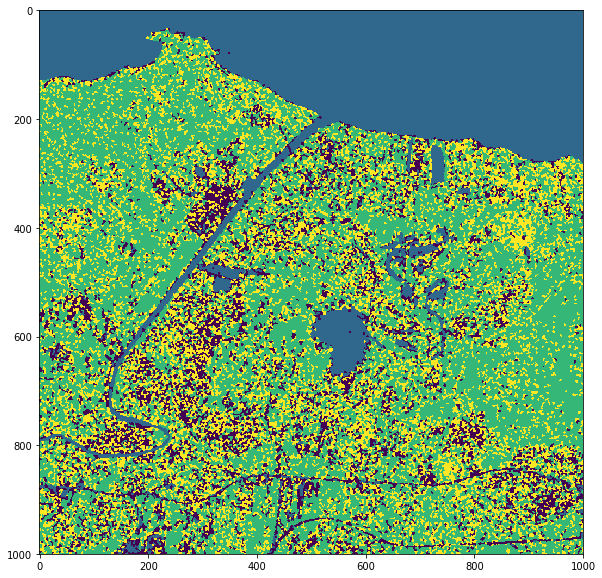

In [15]:
day3_labels=predict(day3_test,kmeans_3clusters)
plt.figure(figsize=(10,10))
plt.imshow(day3_labels)
plt.show()

Using the water cluster label to produce boolean arrays of 'water' at 2 time points and the NumPy logic functions, we can identify areas of water that were not present before the hurricane and were present afterwards.

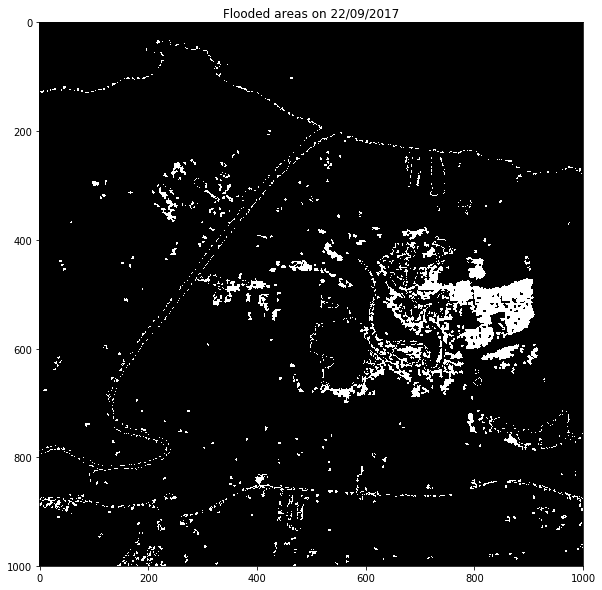

In [16]:
day1_water = day1_labels==water_label
day2_water = day2_labels==water_label

# use exclusive or to identify areas of change
flooding = np.logical_xor(day1_water,day2_water)
plt.figure(figsize=(10,10))
plt.imshow(flooding, 'binary_r')
plt.title('Flooded areas on 22/09/2017')
plt.show()